In [1]:
%config Completer.use_jedi = False
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses
import matplotlib.pyplot as plt
import numpy as np
import os
import logging
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import tensorflow
import tensorflow_probability as tfp
import plotly.express as px
import pandas as pd
from sklearn.mixture import GaussianMixture
import seaborn as sns 

In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [3]:
train_images.shape

(50000, 32, 32, 3)

In [4]:
channel = 2

In [5]:
latent_dim = 4096

class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(latent_dim, activation='relu'),
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(32*32, activation='sigmoid'),
            layers.Reshape((32, 32))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


autoencoder = Autoencoder(latent_dim)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [6]:
# model_dir = f'autoencoder_latent_dim_{latent_dim}_dataset_CIFAR10'
# if os.path.exists(model_dir):
#     print('loading saved model')
#     tf.saved_model.load(export_dir=model_dir)
# else:
#     print('training model')
    
#     autoencoder.fit(train_images[:,:,:,channel], train_images[:,:,:,channel],
#                 epochs=10,
#                 shuffle=True,
#                 validation_data=(test_images[:,:,:,channel], test_images[:,:,:,channel]))
#     print('saving model')
#     tf.saved_model.save(obj=autoencoder,export_dir=model_dir)
autoencoder.fit(train_images[:,:,:,channel], train_images[:,:,:,channel],
                epochs=10,
                shuffle=True,
                validation_data=(test_images[:,:,:,channel], test_images[:,:,:,channel]))

Epoch 1/10
1563/1563 [==============================] - 46s 29ms/step - loss: 0.0225 - val_loss: 0.0050
Epoch 2/10
1563/1563 [==============================] - 46s 29ms/step - loss: 0.0050 - val_loss: 0.0035
Epoch 3/10
1563/1563 [==============================] - 45s 29ms/step - loss: 0.0033 - val_loss: 0.0029
Epoch 4/10
1563/1563 [==============================] - 45s 29ms/step - loss: 0.0028 - val_loss: 0.0023
Epoch 5/10
1563/1563 [==============================] - 43s 27ms/step - loss: 0.0023 - val_loss: 0.0028
Epoch 6/10
1563/1563 [==============================] - 43s 28ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 7/10
1563/1563 [==============================] - 43s 28ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 8/10
1563/1563 [==============================] - 43s 28ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 9/10
1563/1563 [==============================] - 45s 29ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 10/10
1563/1563 [==============================] - 44s 28m

In [7]:
# tf.saved_model.save(obj=autoencoder,export_dir=model_dir)

In [8]:
z = autoencoder.encoder(test_images[:,:,:,channel]).numpy()
decoded_imgs = autoencoder.decoder(z).numpy()

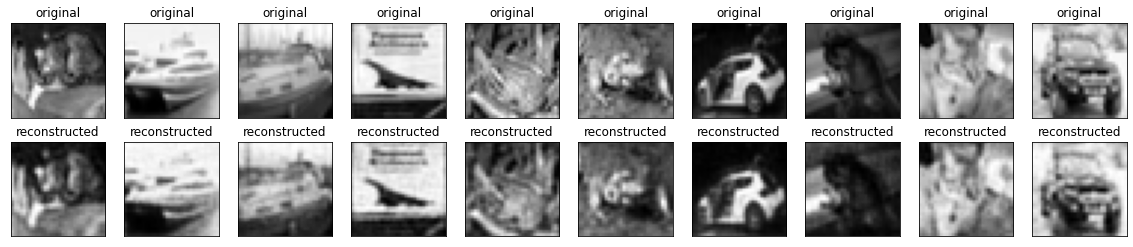

In [9]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_images[i,:,:,channel])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [10]:
def fix_non_positive_definite_matrix(A,eps=0.01):
    logger = logging.getLogger('fix_non_positive_definite_matrix')
    e,v = tf.linalg.eigh(A)
    e_fix = e * tf.cast(tf.greater(e,0),dtype=tf.float32)+eps *tf.cast(tf.less_equal(e,0),dtype=tf.float32)
    A_fix = tf.matmul(v,tf.matmul(tf.linalg.diag(e_fix),tf.transpose(v)))
    A_norm = tf.norm(A)
    A_fix_norm = tf.norm(A_fix)
    corr_err = tf.math.round(1.0*tf.math.abs(A_norm-A_fix_norm)/A_norm,10)
    logger.info(f'Correction error : {corr_err}')
    logger.info(f'VV^T after fixing = {tf.linalg.diag_part(tf.matmul(v,tf.transpose(v)))}')
    return A_fix

In [11]:
def create_Gaussian_Mixture_Model(samples_tensor,k_list=[2,3,4]):
    logger = logging.getLogger('create_Gaussian_Mixture_Model')
    
    samples_np = samples_tensor.numpy()
    min_aic,gm_min_aic = None,None
    for k in k_list:
        gm = GaussianMixture(n_components=k,covariance_type='diag').fit(samples_np)
        gm_means = gm.means_
        gm_cov = gm.covariances_
        at_k_msg = f'At K = {k}'
        logger.info(f'{at_k_msg} - GM means = {gm_means}')
        logger.info(f'{at_k_msg} - GM cov = {gm_cov}')
        aic = gm.aic(samples_np)
        logger.info(f'{at_k_msg} - GM AIC = {aic}')
        logger.info(f'{at_k_msg} - GM Weight {gm.weights_}')
        if min_aic is None:
            min_aic,gm_min_aic = aic,gm
        elif aic < min_aic:
            min_aic,gm_min_aic = aic,gm
        logger.info('------------------------------------')
    
    # create tensorflow gm
    dist_list = []
    for i in range(len(gm_min_aic.means_)):
        means_ = tf.convert_to_tensor(gm_min_aic.means_[i],dtype=tf.float64)
        vars_ = tf.convert_to_tensor(gm_min_aic.covariances_[i],tf.float64)
        mvn_diag = tfp.distributions.MultivariateNormalDiag(loc=means_,scale_diag=vars_)
        dist_list.append(mvn_diag)
    tf_gm = tfp.distributions.Mixture(cat=tfp.distributions.Categorical(probs=gm_min_aic.weights_)\
                                      ,components=dist_list)
    return tf_gm

In [12]:
def calc_z_likelihood(z,raxis = 0):
    logger = logging.getLogger('calc_z_likelihood')
    sample_mean = tf.reduce_max(input_tensor=z,axis=raxis)
    sample_cov = tfp.stats.covariance(x=z)
    sample_cov_fixed  = fix_non_positive_definite_matrix(sample_cov)
    
    e,v = tf.linalg.eigh(tensor=sample_cov_fixed)
    logger.info(f'Eigenvalues for sample covariance marix : shape =  {e.shape} , values = {e}')

    #L = tf.linalg.cholesky(input=sample_cov_fixed)
    
    sample_var = tf.linalg.diag_part(input=sample_cov)+0.1
#     logger.debug(f'sample_mean = {sample_mean.shape}')
#     logger.debug(f'sample_cov = {sample_cov.shape}')
    logger.debug(f'sample_var = {sample_var}')
    mvn_diag = tfp.distributions.MultivariateNormalDiag(loc=sample_mean,scale_diag=sample_var)
    #mvn_tri = tfp.distributions.MultivariateNormalTriL(loc=sample_mean,scale_tril=L)
    log_p_diag = tf.reduce_sum(mvn_diag.log_prob(z))
    #log_p_tri = tf.reduce_sum(mvn_tri.log_prob(z))
    #logger.debug(f' log_p_tri = {log_p_tri}')
    logger.debug(f' log_p_diag = {log_p_diag}')
    #logger.debug(f'Ratio log_p_tri / log_p_diag = {np.round(log_p_tri/log_p_diag,3)}')
    
    # calculate GM model
    gm_diag = create_Gaussian_Mixture_Model(samples_tensor=z)
    log_p_gm_diag = tf.reduce_sum(gm_diag.log_prob(tf.cast(x=z,dtype=tf.float64)))
    
    logger.debug(f'log_p_gm_diag = {log_p_gm_diag}')
    
    logger.debug(f"""Ratio log_p_gm_diag / log_p_mvn_diag = \
            {np.round(log_p_gm_diag/ tf.cast(log_p_diag,tf.float64),3)}""")

INFO:Main:Training autoencoder for label 0 with name airplane


Epoch 1/10
157/157 [==============================] - 5s 29ms/step - loss: 0.0434 - val_loss: 0.0245
Epoch 2/10
157/157 [==============================] - 4s 27ms/step - loss: 0.0234 - val_loss: 0.0172
Epoch 3/10
157/157 [==============================] - 4s 27ms/step - loss: 0.0178 - val_loss: 0.0168
Epoch 4/10
157/157 [==============================] - 4s 27ms/step - loss: 0.0138 - val_loss: 0.0125
Epoch 5/10
157/157 [==============================] - 4s 28ms/step - loss: 0.0114 - val_loss: 0.0097
Epoch 6/10
157/157 [==============================] - 5s 29ms/step - loss: 0.0094 - val_loss: 0.0086
Epoch 7/10
157/157 [==============================] - 4s 28ms/step - loss: 0.0081 - val_loss: 0.0082
Epoch 8/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0069 - val_loss: 0.0072
Epoch 9/10
157/157 [==============================] - 4s 26ms/step - loss: 0.0063 - val_loss: 0.0060
Epoch 10/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0058 - val_lo

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Ugaritic' (NotoSansUgaritic-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Trebuchet MS' (Trebuchet MS Bold Italic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Inscriptional Parthian' (NotoSansInscriptionalParthian-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kohinoor Telugu' (KohinoorTelugu.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Khmer MN' (Khmer MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Trebuchet MS' (Trebuchet MS Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Ly

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Sundanese' (NotoSansSundanese-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.Aqua Kana' (AquaKana.ttc) normal normal 300 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Telugu Sangam MN' (Telugu Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Nadeem' (Nadeem.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Papyrus' (Papyrus.ttc) normal normal 400 condensed>) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Kharoshthi' (NotoSansKharoshthi-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Mono' (SFNSMonoItalic.ttf) italic normal 300 normal>) = 11.

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Verdana' (Verdana Italic.ttf) italic normal 400 normal>) = 4.6863636363636365
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Trebuchet MS' (Trebuchet MS Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Regular.otf) normal normal 600 condensed>) = 10.44
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bangla MN' (Bangla MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Skia' (Skia.ttf) normal normal 5 normal>) = 10.42525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Helvetica' (Helvetica.ttc) normal normal 400 normal>) = 7.322727272727273
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Sinhala Sangam MN' (Sinhala Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kailasa' (Kailasa.ttc) normal normal 400 normal>) = 10.05

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans GB' (Hiragino Sans GB.ttc) normal normal 300 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Rockwell' (Rockwell.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Thonburi' (Thonburi.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Gothic' (NotoSansGothic-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Herculanum' (Herculanum.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W3.ttc) normal normal 300 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Semibold.otf) normal normal 700 condensed>) = 10.535
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Cochin' (Cochin.ttc) normal normal 500 normal>) = 10.145
DEB

DEBUG:matplotlib.font_manager:findfont: score(<Font 'New Peninim MT' (NewPeninimMT.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.Arabic UI Display' (ArabicUIDisplay.ttc) normal normal 900 normal>) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Old South Arabian' (NotoSansOldSouthArabian-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Telugu MN' (Telugu MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSItalic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Luminari' (Luminari.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Serif Myanmar' (NotoSerifMyanmar.ttc) normal normal 900 normal>) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Bold.otf) normal n

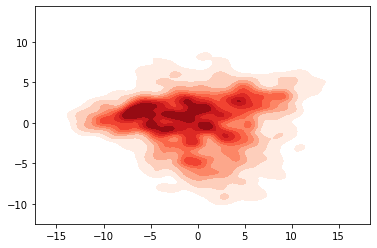

INFO:fix_non_positive_definite_matrix:Correction error : 0.0
INFO:fix_non_positive_definite_matrix:VV^T after fixing = [1.        1.0000122 1.0000092 ... 1.0000178 1.        1.000016 ]
INFO:calc_z_likelihood:Eigenvalues for sample covariance marix : shape =  (4096,) , values = [-3.5720209e-08 -2.5646683e-08 -2.3807688e-08 ...  1.1518189e+01
  1.2526634e+01  2.9206707e+01]
DEBUG:calc_z_likelihood:sample_var = [0.1        0.23392934 0.10110625 ... 0.3553746  0.1        0.24588749]
DEBUG:calc_z_likelihood: log_p_diag = -23526702.0
INFO:create_Gaussian_Mixture_Model:At K = 2 - GM means = [[0.         0.75581407 0.         ... 1.00924837 0.         0.81994669]
 [0.         0.78063259 0.00980583 ... 0.81706793 0.         0.49136272]]
INFO:create_Gaussian_Mixture_Model:At K = 2 - GM cov = [[1.00000000e-06 1.21694894e-01 1.00000000e-06 ... 2.26235864e-01
  1.00000000e-06 1.26132552e-01]
 [1.00000000e-06 1.83309044e-01 5.53925029e-03 ... 3.44495990e-01
  1.00000000e-06 1.39718688e-01]]
INFO:cre

Epoch 1/10
157/157 [==============================] - 4s 26ms/step - loss: 0.0458 - val_loss: 0.0304
Epoch 2/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0228 - val_loss: 0.0190
Epoch 3/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0159 - val_loss: 0.0130
Epoch 4/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0118 - val_loss: 0.0110
Epoch 5/10
157/157 [==============================] - 4s 26ms/step - loss: 0.0091 - val_loss: 0.0126
Epoch 6/10
157/157 [==============================] - 4s 26ms/step - loss: 0.0087 - val_loss: 0.0080
Epoch 7/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0071 - val_loss: 0.0095
Epoch 8/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0068 - val_loss: 0.0066
Epoch 9/10
157/157 [==============================] - 4s 26ms/step - loss: 0.0057 - val_loss: 0.0064
Epoch 10/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0053 - val_lo

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


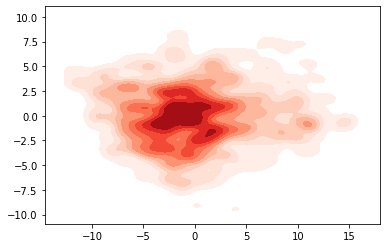

INFO:fix_non_positive_definite_matrix:Correction error : 0.0
INFO:fix_non_positive_definite_matrix:VV^T after fixing = [1.        1.        1.        ... 1.        1.0000186 1.       ]
INFO:calc_z_likelihood:Eigenvalues for sample covariance marix : shape =  (4096,) , values = [-5.4147910e-07 -3.6852686e-07 -3.3702804e-07 ...  8.8848848e+00
  9.8949442e+00  2.8137350e+01]
DEBUG:calc_z_likelihood:sample_var = [0.1        0.1        0.1        ... 0.1        0.10003861 0.1       ]
DEBUG:calc_z_likelihood: log_p_diag = -32560114.0
INFO:create_Gaussian_Mixture_Model:At K = 2 - GM means = [[0.         0.         0.         ... 0.         0.00095069 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
INFO:create_Gaussian_Mixture_Model:At K = 2 - GM cov = [[1.0000000e-06 1.0000000e-06 1.0000000e-06 ... 1.0000000e-06
  1.2533517e-04 1.0000000e-06]
 [1.0000000e-06 1.0000000e-06 1.0000000e-06 ... 1.0000000e-06
  1.0000000e-06 1.0000000e-06]]
INFO:create_Gaussian

Epoch 1/10
157/157 [==============================] - 4s 26ms/step - loss: 0.0427 - val_loss: 0.0261
Epoch 2/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0240 - val_loss: 0.0146
Epoch 3/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0137 - val_loss: 0.0115
Epoch 4/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0087 - val_loss: 0.0084
Epoch 5/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0093 - val_loss: 0.0075
Epoch 6/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0068 - val_loss: 0.0069
Epoch 7/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0057 - val_loss: 0.0058
Epoch 8/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0050 - val_loss: 0.0062
Epoch 9/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0051 - val_loss: 0.0064
Epoch 10/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0053 - val_lo

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


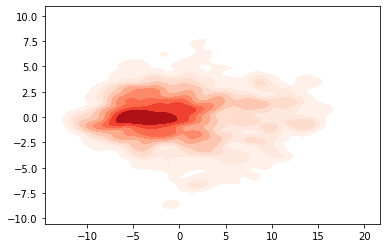

INFO:fix_non_positive_definite_matrix:Correction error : 0.0
INFO:fix_non_positive_definite_matrix:VV^T after fixing = [1.        1.        1.0000198 ... 1.        1.0000141 1.       ]
INFO:calc_z_likelihood:Eigenvalues for sample covariance marix : shape =  (4096,) , values = [-4.0787958e-07 -1.1463854e-07 -6.3699773e-08 ...  4.5895796e+00
  6.1950321e+00  3.4636799e+01]
DEBUG:calc_z_likelihood:sample_var = [0.1       0.1       0.3289352 ... 0.1       0.2716688 0.1      ]
DEBUG:calc_z_likelihood: log_p_diag = -38772536.0
INFO:create_Gaussian_Mixture_Model:At K = 2 - GM means = [[0.         0.         0.6578417  ... 0.         0.4014155  0.        ]
 [0.         0.         0.84184693 ... 0.         0.79998734 0.        ]]
INFO:create_Gaussian_Mixture_Model:At K = 2 - GM cov = [[1.00000000e-06 1.00000000e-06 2.05105625e-01 ... 1.00000000e-06
  8.42031893e-02 1.00000000e-06]
 [1.00000000e-06 1.00000000e-06 2.28496477e-01 ... 1.00000000e-06
  1.61097183e-01 1.00000000e-06]]
INFO:create_Ga

Epoch 1/10
157/157 [==============================] - 4s 26ms/step - loss: 0.0454 - val_loss: 0.0517
Epoch 2/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0255 - val_loss: 0.0161
Epoch 3/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0149 - val_loss: 0.0125
Epoch 4/10
157/157 [==============================] - 4s 26ms/step - loss: 0.0121 - val_loss: 0.0081
Epoch 5/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0072 - val_loss: 0.0089
Epoch 6/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0074 - val_loss: 0.0067
Epoch 7/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0056 - val_loss: 0.0059
Epoch 8/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0056 - val_loss: 0.0051
Epoch 9/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0046 - val_loss: 0.0048
Epoch 10/10
157/157 [==============================] - 4s 26ms/step - loss: 0.0044 - val_lo

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


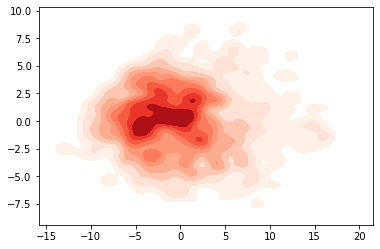

INFO:fix_non_positive_definite_matrix:Correction error : 0.0
INFO:fix_non_positive_definite_matrix:VV^T after fixing = [1.0000218 1.0000076 1.000015  ... 1.0000182 1.        1.       ]
INFO:calc_z_likelihood:Eigenvalues for sample covariance marix : shape =  (4096,) , values = [-7.9403679e-07 -2.5105035e-07 -1.8430663e-07 ...  7.0836234e+00
  9.4560347e+00  2.9780323e+01]
DEBUG:calc_z_likelihood:sample_var = [0.18586427 0.1        0.25727072 ... 0.16250303 0.1        0.1       ]
DEBUG:calc_z_likelihood: log_p_diag = -45396852.0
INFO:create_Gaussian_Mixture_Model:At K = 2 - GM means = [[0.44743102 0.         0.48074064 ... 0.38177825 0.         0.        ]
 [0.53629669 0.         0.73196667 ... 0.44873934 0.         0.        ]]
INFO:create_Gaussian_Mixture_Model:At K = 2 - GM cov = [[1.02509995e-01 1.00000000e-06 1.24135443e-01 ... 6.99060017e-02
  1.00000000e-06 1.00000000e-06]
 [7.66945228e-02 1.00000000e-06 1.52508686e-01 ... 5.81419471e-02
  1.00000000e-06 1.00000000e-06]]
INFO:cre

Epoch 1/10
157/157 [==============================] - 4s 26ms/step - loss: 0.0394 - val_loss: 0.0239
Epoch 2/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0215 - val_loss: 0.0179
Epoch 3/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0125 - val_loss: 0.0086
Epoch 4/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0073 - val_loss: 0.0067
Epoch 5/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0068 - val_loss: 0.0090
Epoch 6/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0072 - val_loss: 0.0058
Epoch 7/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0055 - val_loss: 0.0052
Epoch 8/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0050 - val_loss: 0.0048
Epoch 9/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0046 - val_loss: 0.0075
Epoch 10/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0043 - val_lo

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


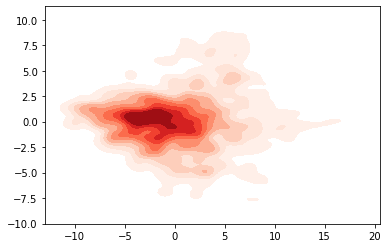

INFO:fix_non_positive_definite_matrix:Correction error : 0.0
INFO:fix_non_positive_definite_matrix:VV^T after fixing = [1.        1.        1.        ... 1.0000176 1.0000267 1.       ]
INFO:calc_z_likelihood:Eigenvalues for sample covariance marix : shape =  (4096,) , values = [-6.0379421e-07 -2.5674953e-07 -2.2834163e-08 ...  3.3570707e+00
  6.6780844e+00  2.1869616e+01]
DEBUG:calc_z_likelihood:sample_var = [0.1        0.1        0.1        ... 0.12574726 0.10001057 0.1       ]
DEBUG:calc_z_likelihood: log_p_diag = -22923584.0
INFO:create_Gaussian_Mixture_Model:At K = 2 - GM means = [[0.         0.         0.         ... 0.38006552 0.00099009 0.        ]
 [0.         0.         0.         ... 0.34566214 0.         0.        ]]
INFO:create_Gaussian_Mixture_Model:At K = 2 - GM cov = [[1.00000000e-06 1.00000000e-06 1.00000000e-06 ... 2.77544178e-02
  5.92130578e-05 1.00000000e-06]
 [1.00000000e-06 1.00000000e-06 1.00000000e-06 ... 2.50989898e-02
  1.00000000e-06 1.00000000e-06]]
INFO:cre

Epoch 1/10
157/157 [==============================] - 4s 26ms/step - loss: 0.0433 - val_loss: 0.0233
Epoch 2/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0228 - val_loss: 0.0178
Epoch 3/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0156 - val_loss: 0.0106
Epoch 4/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0097 - val_loss: 0.0119
Epoch 5/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0095 - val_loss: 0.0068
Epoch 6/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0064 - val_loss: 0.0063
Epoch 7/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0054 - val_loss: 0.0053
Epoch 8/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0052 - val_loss: 0.0084
Epoch 9/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0048 - val_loss: 0.0048
Epoch 10/10
157/157 [==============================] - 4s 26ms/step - loss: 0.0043 - val_lo

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


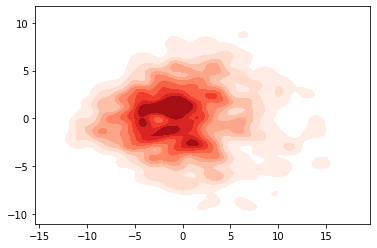

INFO:fix_non_positive_definite_matrix:Correction error : 0.0
INFO:fix_non_positive_definite_matrix:VV^T after fixing = [1.        1.0000275 1.0000023 ... 1.        1.        1.       ]
INFO:calc_z_likelihood:Eigenvalues for sample covariance marix : shape =  (4096,) , values = [-3.4877141e-07 -2.6281074e-07 -2.1587422e-07 ...  7.2597108e+00
  1.1332207e+01  2.4777645e+01]
DEBUG:calc_z_likelihood:sample_var = [0.1        0.10423632 0.10057898 ... 0.1        0.1        0.1       ]
DEBUG:calc_z_likelihood: log_p_diag = -36382480.0
INFO:create_Gaussian_Mixture_Model:At K = 2 - GM means = [[0.         0.03232959 0.00564087 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
INFO:create_Gaussian_Mixture_Model:At K = 2 - GM cov = [[1.00000000e-06 1.49853851e-02 2.13007029e-03 ... 1.00000000e-06
  1.00000000e-06 1.00000000e-06]
 [1.00000000e-06 1.00000000e-06 1.00000000e-06 ... 1.00000000e-06
  1.00000000e-06 1.00000000e-06]]
INFO:cre

Epoch 1/10
157/157 [==============================] - 4s 26ms/step - loss: 0.0400 - val_loss: 0.0228
Epoch 2/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0207 - val_loss: 0.0111
Epoch 3/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0115 - val_loss: 0.0128
Epoch 4/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0087 - val_loss: 0.0070
Epoch 5/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0068 - val_loss: 0.0100
Epoch 6/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0061 - val_loss: 0.0062
Epoch 7/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0052 - val_loss: 0.0105
Epoch 8/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0060 - val_loss: 0.0049
Epoch 9/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0049 - val_loss: 0.0045
Epoch 10/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0045 - val_lo

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


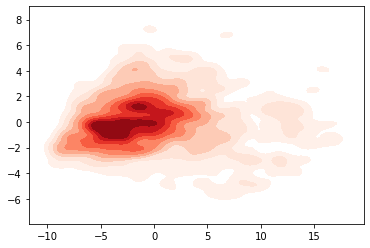

INFO:fix_non_positive_definite_matrix:Correction error : 0.0
INFO:fix_non_positive_definite_matrix:VV^T after fixing = [1.        1.        1.        ... 1.0000162 1.0000141 1.0000166]
INFO:calc_z_likelihood:Eigenvalues for sample covariance marix : shape =  (4096,) , values = [-6.9365370e-07 -2.2954612e-07 -9.3490080e-08 ...  3.6123157e+00
  4.7129555e+00  2.7462952e+01]
DEBUG:calc_z_likelihood:sample_var = [0.1        0.1        0.1        ... 0.13200223 0.10000969 0.1062388 ]
DEBUG:calc_z_likelihood: log_p_diag = -34493848.0
INFO:create_Gaussian_Mixture_Model:At K = 2 - GM means = [[0.         0.         0.         ... 0.27475068 0.00031079 0.07886009]
 [0.         0.         0.         ... 0.29723306 0.         0.00095133]]
INFO:create_Gaussian_Mixture_Model:At K = 2 - GM cov = [[1.00000000e-06 1.00000000e-06 1.00000000e-06 ... 3.15816894e-02
  3.15223381e-05 1.53481899e-02]
 [1.00000000e-06 1.00000000e-06 1.00000000e-06 ... 3.20386392e-02
  1.00000000e-06 8.82190725e-05]]
INFO:cre

Epoch 1/10
157/157 [==============================] - 4s 26ms/step - loss: 0.0418 - val_loss: 0.0225
Epoch 2/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0208 - val_loss: 0.0192
Epoch 3/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0143 - val_loss: 0.0105
Epoch 4/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0098 - val_loss: 0.0084
Epoch 5/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0084 - val_loss: 0.0079
Epoch 6/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0065 - val_loss: 0.0072
Epoch 7/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0057 - val_loss: 0.0058
Epoch 8/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0052 - val_loss: 0.0060
Epoch 9/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0054 - val_loss: 0.0059
Epoch 10/10
157/157 [==============================] - 4s 26ms/step - loss: 0.0048 - val_lo

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


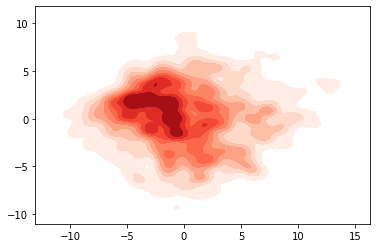

INFO:fix_non_positive_definite_matrix:Correction error : 0.0
INFO:fix_non_positive_definite_matrix:VV^T after fixing = [1.        1.        1.0000205 ... 1.        1.0000198 1.       ]
INFO:calc_z_likelihood:Eigenvalues for sample covariance marix : shape =  (4096,) , values = [-2.6836454e-07 -2.1040957e-07 -1.3563037e-07 ...  7.0537648e+00
  1.0980487e+01  1.8919231e+01]
DEBUG:calc_z_likelihood:sample_var = [0.1        0.1        0.15782209 ... 0.1        0.1172251  0.1       ]
DEBUG:calc_z_likelihood: log_p_diag = -44453696.0
INFO:create_Gaussian_Mixture_Model:At K = 2 - GM means = [[0.         0.         0.39675479 ... 0.         0.08507194 0.        ]
 [0.         0.         0.40268016 ... 0.         0.01829233 0.        ]]
INFO:create_Gaussian_Mixture_Model:At K = 2 - GM cov = [[1.00000000e-06 1.00000000e-06 6.13933545e-02 ... 1.00000000e-06
  4.83286386e-02 1.00000000e-06]
 [1.00000000e-06 1.00000000e-06 5.68895483e-02 ... 1.00000000e-06
  8.23802989e-03 1.00000000e-06]]
INFO:cre

Epoch 1/10
157/157 [==============================] - 4s 26ms/step - loss: 0.0336 - val_loss: 0.0186
Epoch 2/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0174 - val_loss: 0.0155
Epoch 3/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0136 - val_loss: 0.0112
Epoch 4/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0109 - val_loss: 0.0091
Epoch 5/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0094 - val_loss: 0.0081
Epoch 6/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0084 - val_loss: 0.0074
Epoch 7/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0067 - val_loss: 0.0058
Epoch 8/10
157/157 [==============================] - 4s 26ms/step - loss: 0.0057 - val_loss: 0.0052
Epoch 9/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0056 - val_loss: 0.0062
Epoch 10/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0053 - val_lo

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


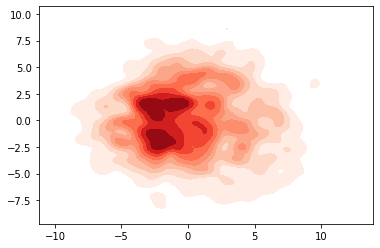

INFO:fix_non_positive_definite_matrix:Correction error : 0.0
INFO:fix_non_positive_definite_matrix:VV^T after fixing = [1.0000118 1.0000176 1.0000045 ... 1.        1.0000165 1.       ]
INFO:calc_z_likelihood:Eigenvalues for sample covariance marix : shape =  (4096,) , values = [-3.30260583e-08 -2.37745574e-08 -2.21912391e-08 ...  6.95183897e+00
  9.88646126e+00  1.33064165e+01]
DEBUG:calc_z_likelihood:sample_var = [0.11215804 0.17641856 0.1        ... 0.1        0.15189949 0.1       ]
DEBUG:calc_z_likelihood: log_p_diag = -25651778.0
INFO:create_Gaussian_Mixture_Model:At K = 2 - GM means = [[0.10681657 0.4447818  0.         ... 0.         0.42516652 0.        ]
 [0.         0.46924272 0.         ... 0.         0.30697727 0.        ]]
INFO:create_Gaussian_Mixture_Model:At K = 2 - GM cov = [[5.02375526e-02 1.02441729e-01 1.00000000e-06 ... 1.00000000e-06
  6.81585631e-02 1.00000000e-06]
 [1.00000000e-06 6.95867669e-02 1.00000000e-06 ... 1.00000000e-06
  4.48445759e-02 1.00000000e-06]]
IN

Epoch 1/10
157/157 [==============================] - 4s 26ms/step - loss: 0.0431 - val_loss: 0.0230
Epoch 2/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0208 - val_loss: 0.0170
Epoch 3/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0155 - val_loss: 0.0129
Epoch 4/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0118 - val_loss: 0.0127
Epoch 5/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0101 - val_loss: 0.0096
Epoch 6/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0088 - val_loss: 0.0083
Epoch 7/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0081 - val_loss: 0.0072
Epoch 8/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0069 - val_loss: 0.0077
Epoch 9/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0062 - val_loss: 0.0061
Epoch 10/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0055 - val_lo

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


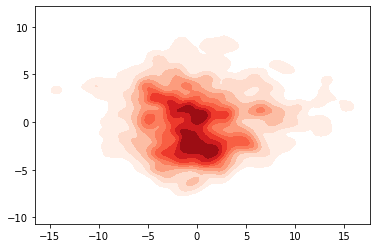

INFO:fix_non_positive_definite_matrix:Correction error : 0.0
INFO:fix_non_positive_definite_matrix:VV^T after fixing = [1.0000521 1.0000006 1.0000031 ... 1.0000165 1.        1.0000143]
INFO:calc_z_likelihood:Eigenvalues for sample covariance marix : shape =  (4096,) , values = [-5.92182460e-07 -3.79704233e-07 -1.12603196e-07 ...  8.80128574e+00
  1.01575499e+01  2.08146019e+01]
DEBUG:calc_z_likelihood:sample_var = [0.10008547 0.1        0.10002001 ... 0.2478059  0.1        0.18635617]
DEBUG:calc_z_likelihood: log_p_diag = -24589086.0
INFO:create_Gaussian_Mixture_Model:At K = 2 - GM means = [[0.         0.         0.         ... 0.61597113 0.         0.46996851]
 [0.00169918 0.         0.00067857 ... 0.41554767 0.         0.3678942 ]]
INFO:create_Gaussian_Mixture_Model:At K = 2 - GM cov = [[1.00000000e-06 1.00000000e-06 1.00000000e-06 ... 1.47371021e-01
  1.00000000e-06 8.00752415e-02]
 [3.50509711e-04 1.00000000e-06 8.29782670e-05 ... 1.18756322e-01
  1.00000000e-06 9.80395345e-02]]
IN

In [13]:
###### unique_labels = np.unique(train_labels)

logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger('Main')
############
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger('Main')
auto_encoders = dict()
train_labels2 = np.transpose(train_labels)[0]
test_labels2 = np.transpose(test_labels)[0]
unique_labels = np.unique(train_labels2)
for label in unique_labels:
    train_idx = train_labels2==label
    test_idx = test_labels2 == label
    
    train_images_label = train_images[train_idx,:,:,channel]
    test_images_label = test_images[test_idx,:,:,channel]
    
#     print(class_names[label])
#     plt.imshow(train_images_label[0,:,:])
#     plt.show()
    logger.info(f'Training autoencoder for label {label} with name {class_names[label]}')
    auto_encoders[label] = autoencoder = Autoencoder(latent_dim)
    auto_encoders[label].compile(optimizer='adam', loss=losses.MeanSquaredError())
    auto_encoders[label].fit(train_images_label, train_images_label,
                epochs=10,
                shuffle=True,
                validation_data=(test_images_label, test_images_label))
    
    z = auto_encoders[label].encoder(test_images_label)
    if z.shape[0] >2:
        logger.info('Apply PCA for 2D plot of Z')
        s = StandardScaler()
        z_scaled = s.fit(z)
        pca = PCA(n_components=2)
        z_pca = pca.fit_transform(z)
        z1 = z_pca[:,0]
        z2 = z_pca[:,1]
    elif z.shape[0] == 2:
        z1 = z[:,0].numpy()
        z2 = z[:,1].numpy()
    else:
        raise ValueError('Z shape must be >=2')
    # plt.hist2d(z1, z2, bins=(50, 50), cmap=plt.cm.jet)
    # plt.show()
    sns.kdeplot(pd.Series(z1), pd.Series(z2), cmap="Reds", shade=True, bw=.15)
    plt.show()
    
    calc_z_likelihood(z=z)
